# Spotify Recommender Part 1 - Data Preprocessing

To do:
- check API reference for additional data that can be pulled in for artist/genres
- join data via sql
- clean data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from secrets import SPOTIFY_HISTORY_DB

## Import Data

First we setup the connection to the SQL DB which contains 3 tables:
- **streaming_history**: each song listened to starting 02-01-2021
- **genres**: each of the artists from streaming_history, tagged with their corresponding genre
- **song_features**: each track from streaming_history, with details at the song level 
    - details include corresponding track values (liveness, tempo, valence etc.)

In [2]:
conn = sqlite3.connect(SPOTIFY_HISTORY_DB)

df_sh = pd.read_sql_query("SELECT * FROM streaming_history", conn)
df_genres = pd.read_sql_query("SELECT * FROM genres", conn)
df_features = pd.read_sql_query("SELECT * FROM song_features", conn)

In [3]:
df_sh.tail(1)

,spotify_id,uri,song_name,artist_name,played_at,duration_ms,date,ETL_DTTM,artist_uri
4646,2RuAqFvXGSKrM8jIrd0uqV,spotify:track:2RuAqFvXGSKrM8jIrd0uqV,Drip (feat. Emis Killa),Young Rame,2021-10-08 07:55:41.228000,128400,2021-10-08,"2021-10-09, 10:44:58",2Nl7TO1yi0ambHrlfQORgv


In [4]:
df_genres.head(1)

,spotify_url,total_followers,genres,artist_id,artist_name,popularity,uri,ETL_DTTM
0,https://open.spotify.com/artist/3SFVIUlipGj3Rp...,48610,"['bass trap', 'traprun']",3SFVIUlipGj3RpWCKe9s73,Lox Chatterbox,58,spotify:artist:3SFVIUlipGj3RpWCKe9s73,"2021-02-14, 09:25:59"


In [5]:
df_features.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,ETL_DTTM
0,0.754,0.763,1,-6.57,1,0.295,0.32,0.0,0.143,0.704,159.963,audio_features,5ZcmLAogrj4HF8Odrz9XA2,spotify:track:5ZcmLAogrj4HF8Odrz9XA2,https://api.spotify.com/v1/tracks/5ZcmLAogrj4H...,https://api.spotify.com/v1/audio-analysis/5Zcm...,265693,3,"2021-02-04, 23:13:23"


The final query merges the data from the 3 tables into one master table, removing any potential duplicate records. If the same song was played over multiple days, there would be many.

In [6]:
merged_query = """
SELECT DISTINCT sh.spotify_id
    ,sh.uri
    ,sh.song_name
    ,sh.artist_name
    ,sh.artist_uri
    ,sh.played_at
    ,sh.date
    ,ETL_DTTM
    ,g.genres
    ,g.popularity
    ,sf.*
FROM streaming_history sh 
LEFT JOIN (SELECT DISTINCT *
    FROM (SELECT DISTINCT artist_id 
                ,artist_name
                ,genres
                ,popularity
                ,row_number() over (partition by artist_id order by artist_id, ETL_DTTM) as dup
            FROM genres)
    WHERE dup = 1) g
ON sh.artist_uri = g.artist_id
LEFT JOIN (SELECT DISTINCT id -- spotify track id
    ,danceability
    ,energy
    ,"key"
    ,loudness
    ,mode
    ,speechiness
    ,acousticness
    ,instrumentalness
    ,liveness
    ,valence
    ,tempo
    ,duration_ms
    ,time_signature
FROM song_features) sf
ON sh.spotify_id = sf.id
order by played_at
"""

df_spotify = pd.read_sql_query(merged_query, conn)

In [7]:
df_spotify.tail()

,spotify_id,uri,song_name,artist_name,artist_uri,played_at,date,ETL_DTTM,genres,popularity,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
4642,1R6kyTcW6aRzYtsMA2LhZl,spotify:track:1R6kyTcW6aRzYtsMA2LhZl,Meri Zindagi (feat. In-s),Alrima,2XyVj5qsjy87RPXk1O5if3,2021-10-08 23:07:24.779000,2021-10-08,"2021-10-09, 10:44:58","['francoton', 'french hip hop', 'pop urbaine',...",50.0,...,-7.128,0.0,0.2140,0.2200,0.000000,0.1530,0.918,191.959,145000.0,4.0
4643,4cNkAkSkfDSqZnorvW6LJ8,spotify:track:4cNkAkSkfDSqZnorvW6LJ8,SKYLINE,Emmeti,2DHPLzqLl0BDYIatbRoWy3,2021-10-08 23:10:27.866000,2021-10-08,"2021-10-09, 10:44:58",[],8.0,...,-5.545,0.0,0.0663,0.0156,0.000002,0.1950,0.393,199.787,177331.0,4.0
4644,619SqmXi8PXC2vEmfzxpsu,spotify:track:619SqmXi8PXC2vEmfzxpsu,Sourire,Benab,0qO3t2MHM5NIEJ5fw9VndY,2021-10-08 23:13:39.368000,2021-10-08,"2021-10-09, 10:44:58","['francoton', 'french hip hop', 'pop urbaine',...",64.0,...,-5.657,0.0,0.0559,0.0410,0.000000,0.0722,0.742,115.026,190293.0,4.0
4645,0rq240T7TbjPGjECKie6DA,spotify:track:0rq240T7TbjPGjECKie6DA,Hasta la vista,Nerone,7kG6A2lZMXeaD5YkubF5Kn,2021-10-08 23:15:35.037000,2021-10-08,"2021-10-09, 10:44:58",['italian hip hop'],54.0,...,-4.841,1.0,0.1210,0.3160,0.000000,0.1970,0.417,97.063,141031.0,4.0
4646,2RuAqFvXGSKrM8jIrd0uqV,spotify:track:2RuAqFvXGSKrM8jIrd0uqV,Drip (feat. Emis Killa),Young Rame,2Nl7TO1yi0ambHrlfQORgv,2021-10-08 23:17:43.584000,2021-10-08,"2021-10-09, 10:44:58",['italian hip hop'],52.0,...,-5.512,1.0,0.0559,0.0860,0.000006,0.1110,0.471,99.995,128400.0,4.0


## EDA & Data Cleaning

In [8]:
print("Total number of songs streamed: ", len(df_spotify))
print("Number of unique songs: ", len(df_spotify.spotify_id.unique()))
print("Number of unique artists: ", len(df_spotify.artist_uri.unique()))

Total number of songs streamed:  4647
Number of unique songs:  1158
Number of unique artists:  421


In [9]:
df_spotify.dtypes

spotify_id           object
uri                  object
song_name            object
artist_name          object
artist_uri           object
played_at            object
date                 object
ETL_DTTM             object
genres               object
popularity          float64
id                   object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms         float64
time_signature      float64
dtype: object

In [10]:
df_spotify['genres'].values[4362]

"['belgian dance', 'belgian edm', 'big room', 'dance pop', 'edm', 'electro house', 'pop dance', 'progressive electro house', 'tropical house']"

We see that the genres column appears to be a list at first glance, but is not actually in a list format:

In [11]:
df_spotify['genres'].values[4362][0]

'['

To fix this, a Regular Expression (regex) statement will be used to return a list for each genre. For records without a genre, an empty list will be input.

In [12]:
df_spotify['genres'] = df_spotify['genres'].fillna('[]').apply(lambda x: [re.sub(' ', '_', i) for i in re.findall(r"'([^']*)'", x)])

In [13]:
df_spotify['genres'].values[4362][0]

'belgian_dance'

In [14]:
# create list of columns which are numeric
num = df_spotify.select_dtypes(include=np.number)
column_list = num.columns.to_list()

At this point I would like to visualize the distribution of the many data points available. Some knowledge of key attributes may help with model building later on. 

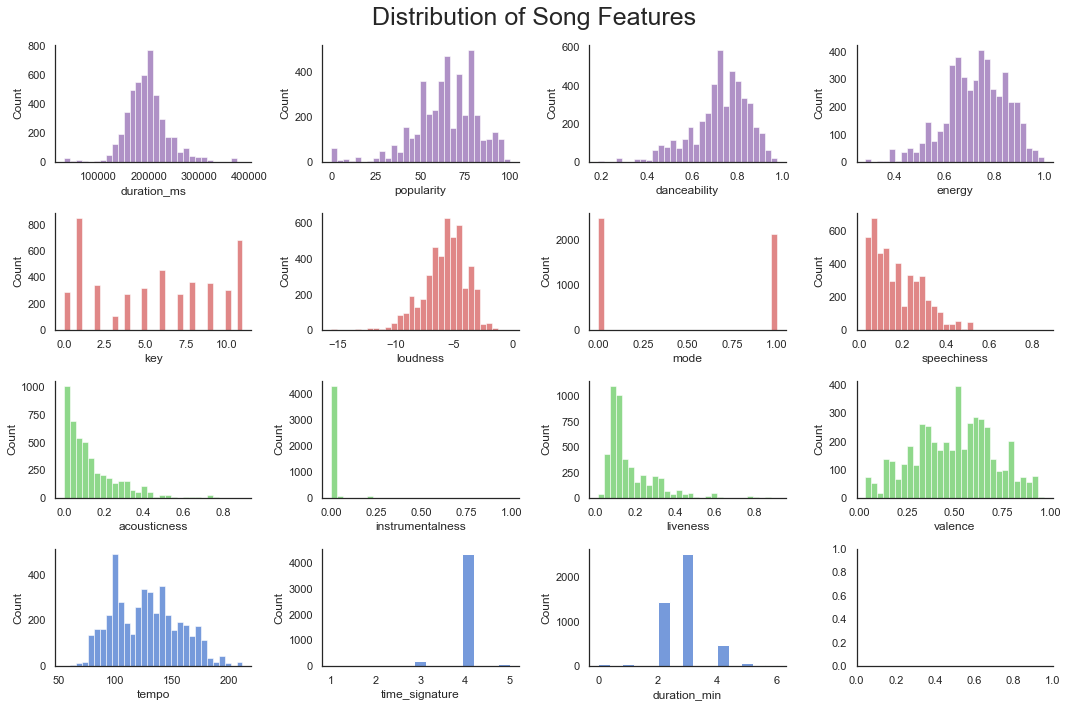

In [15]:
sns.set(style="white", palette="muted", color_codes=True)

fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharex=False)
sns.despine(right=True)

sns.histplot(df_spotify['duration_ms'], kde=False, bins=30, ax=axes[0, 0], color="m")
sns.histplot(df_spotify['popularity'], kde=False, bins=30, ax=axes[0, 1], color="m")
sns.histplot(df_spotify['danceability'], kde=False, bins=30, ax=axes[0, 2], color="m")
sns.histplot(df_spotify['energy'], kde=False, bins=30, ax=axes[0, 3], color="m")

sns.histplot(df_spotify['key'], kde=False, bins=30, ax=axes[1, 0], color="r")
sns.histplot(df_spotify['loudness'], kde=False, bins=30, ax=axes[1, 1], color="r")
sns.histplot(df_spotify['mode'], kde=False, bins=30, ax=axes[1, 2], color="r")
sns.histplot(df_spotify['speechiness'], kde=False, bins=30, ax=axes[1, 3], color="r")

sns.histplot(df_spotify['acousticness'], kde=False, bins=30, ax=axes[2, 0], color="g")
sns.histplot(df_spotify['instrumentalness'], kde=False, bins=30, ax=axes[2, 1], color="g")
sns.histplot(df_spotify['liveness'], kde=False, bins=30, ax=axes[2, 2], color="g")
sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[2, 3], color="g")

sns.histplot(df_spotify['tempo'], kde=False, bins=30, ax=axes[3, 0])
sns.histplot(df_spotify['time_signature'], kde=False, bins=15, ax=axes[3, 1])
sns.histplot(df_spotify['duration_ms']//60000, kde=False, bins=15, ax=axes[3, 2]).set_xlabel('duration_min')
#sns.histplot(df_spotify['valence'], kde=False, bins=30, ax=axes[3, 3])

plt.suptitle('Distribution of Song Features', fontsize=25)
plt.tight_layout()

Below we can see that the majority of tracks were played less than 10 times (frequency).

In [16]:
playback_count = df_spotify.groupby(['song_name', 'artist_name', 'spotify_id']).size().to_frame('count').sort_values(['count'], ascending=False).reset_index()

Text(0.5, 1.0, 'Distribution of Song Playback Frequency')

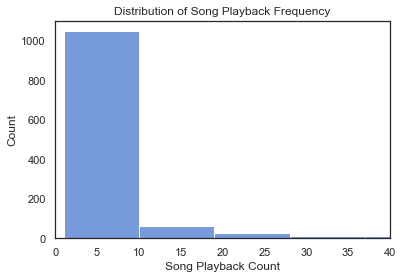

In [17]:
sns.histplot(playback_count['count'], bins=10).set(xlim=(0,40))
plt.xlabel('Song Playback Count')
plt.ylabel('Count')
plt.title('Distribution of Song Playback Frequency')

# ax = playback_count.plot(kind='hist', bins=9)
# ax.set_xlim(0,40)
# ax.set_title("Distribution of Playback Frequency")

In [18]:
playback_count[playback_count['count']<=10]

,song_name,artist_name,spotify_id,count
104,F.W.T.S / Active,Krept & Konan,1CoYysyP3yJMEmG3b6fm5T,10
105,No Excuses,NF,7ssFG94tZHpX9vbIFM0GVH,10
106,Heavy Heavy (feat. Tempo),Wisin,32x8lPZ4nidLsF0d0qM5KG,10
107,My Business (feat. Future),NAV,2AEtYwT9qg2eY6G9m8wOxW,10
108,Boheme,Nebezao,1fiTU4uiKwGOCkcbYOB5X7,10
...,...,...,...,...
1156,In My Heart (ASOT 1034) - Richard Durand Remix,Armin van Buuren,35ZI84vdNoBozpBgD6gAnf,1
1157,Inception,Robyn Sandhu,1VCoCJDZZ5Sk5KXKy2JHRV,1
1158,Inseguimento,MR Rizzus,2KhNKmYgYbTQMKmaXprIBl,1
1159,Interlude (Ora è la mia ora),Capo Plaza,67bErrb52zG9KvfubrDysb,1


In [20]:
df_spotify.groupby(['song_name', 'artist_name', 'spotify_id']).size().to_frame('count').sort_values(['count'], ascending=False).reset_index()

,song_name,artist_name,spotify_id,count
0,Puertosol Golden Coast,Vegas Jones,2oZagYx3ZyigFqguLrbon9,91
1,AMG,Sacky,63ZHGDgE804BwJfCZkX1Vy,85
2,Plain Jane,A$AP Ferg,4dVpf9jZjcORqGTLUaeYj9,59
3,"Shotta 2 (feat. Vale Pain, Baby Gang, Nko)",RM4E,3YXOKfDchF2QRNXXJpgmCx,50
4,Dope Money,Lox Chatterbox,0wnh82DXx3anpAHE9wflCw,46
...,...,...,...,...
1156,In My Heart (ASOT 1034) - Richard Durand Remix,Armin van Buuren,35ZI84vdNoBozpBgD6gAnf,1
1157,Inception,Robyn Sandhu,1VCoCJDZZ5Sk5KXKy2JHRV,1
1158,Inseguimento,MR Rizzus,2KhNKmYgYbTQMKmaXprIBl,1
1159,Interlude (Ora è la mia ora),Capo Plaza,67bErrb52zG9KvfubrDysb,1


In [21]:
pd.read_sql_query("""
SELECT DISTINCT spotify_id, song_name, artist_name, Count(*) AS playback_count 
FROM streaming_history 
GROUP BY 1,2,3
""", conn)

,spotify_id,song_name,artist_name,playback_count
0,00iRsSA9GeWcSeUtqpad84,Не пускайте танцевать,Timran,1
1,01IQ4aQgOf0Kkq3a273hmO,Funky Friday,Dave,1
2,01SyViM4lbRtUS9h5Vq1Zy,Little More Love,AJ Tracey,1
3,0259eSt61D349yZvwily88,Aquí (feat. Ozuna & Soolking),AriBeatz,1
4,02BJ8AciQdCFqevG4UfVe1,Equipe (feat. Shiva),Philip,1
...,...,...,...,...
1156,7ycWLEP1GsNjVvcjawXz3z,Praise The Lord (Da Shine) (feat. Skepta),A$AP Rocky,2
1157,7yyOgLLZVDbiqKugL5m6ly,"C C (feat. Pyrex, Wayne)",Dark Polo Gang,2
1158,7zVVkNOKWMd46nwMUgHPmL,Run My Shit,Mindflip,1
1159,7zfmu6GIyvkfDzp3X1Gj3R,Papparapa',Nerone,7
